In [1]:
#!pip install albumentations==0.4.6

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda, 'Albumentations version', A.__version__)

CUDA Available? True Albumentations version 1.3.1


In [4]:
import os
import sys
sys.path.insert(0,'/content/drive/MyDrive/ERAV2/Assignment9')
%cd /content/drive/MyDrive/ERAV2/Assignment9
%pwd

/content/drive/MyDrive/ERAV2/Assignment9


'/content/drive/MyDrive/ERAV2/Assignment9'

In [6]:
from model import Dilated_Net
from utils import plot_performance

In [7]:
# Train Phase transformations
train_transforms = A.Compose([        #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       A.HorizontalFlip(p=0.2),
                                      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                                      A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.49139968, 0.48215841, 0.44653091),mask_fill_value = None),
                                      # A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.2),
                                      A.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1, p=0.2),
                                       A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                      ToTensorV2()
                                        ])

# Test Phase transformations
test_transforms = A.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                      ToTensorV2()

                                       ])


In [8]:
class Albumentations_CIFAR10(datasets.CIFAR10):
  def __init__(self, root="../data", train=True, download=True, transform=None):
    super().__init__( root=root, train=train, download=download, transform=transform)

  def __getitem__(self, index):
    image, label = self.data[index], self.targets[index]

    if self.transform is not None:
      transformed = self.transform(image=image)
      image = transformed["image"]
    return image, label

In [9]:
train = Albumentations_CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = Albumentations_CIFAR10('../data', train=False, download=True, transform=test_transforms)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
train_data = train.data/255

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', torch.tensor(train.data).size())
print(' - min:', torch.min(torch.tensor(train_data)))
print(' - max:', torch.max(torch.tensor(train_data)))
print(' - mean:', train_data.mean(axis = (0,1,2)))
print(' - std:', train_data.std(axis = (0,1,2)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0., dtype=torch.float64)
 - max: tensor(1., dtype=torch.float64)
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
torch.Size([512, 3, 32, 32])
torch.Size([512])


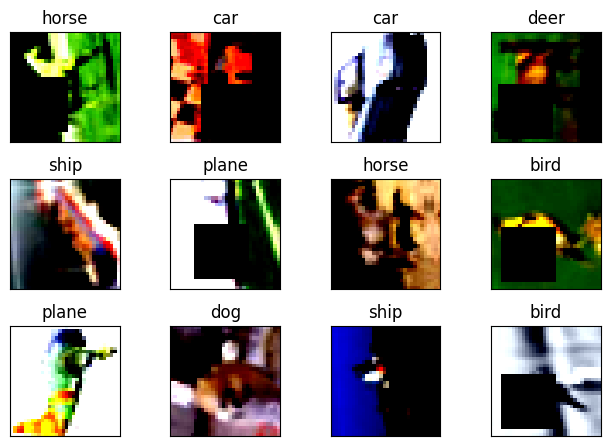

In [12]:
import matplotlib.pyplot as plt
import numpy as np
batch_data, batch_label = next(iter(train_loader))
fig = plt.figure()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(batch_data[i].numpy(), (2, 1, 0)), cmap='gray')
    plt.title(f'{classes[batch_label[i].item()]}')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [13]:
def calc_activation_shape(dim, ksize, dilation=(1, 1), stride=(1, 1), padding=(0, 0)):
  def shape_each_dim(i):
    odim_i = dim[i] + 2 * padding[i] - dilation[i] * (ksize[i] - 1) - 1
    return (odim_i / stride[i]) + 1
  return shape_each_dim(0), shape_each_dim(1)

def calc_receptive_field(Rin,ksize, stride, Jin, dilation=1):
    new_k = (ksize - 1)
    if dilation>1:
      Jnew = Jin*dilation
    else:
      Jnew = stride*Jin
    return Rin + new_k*Jin, Jnew

In [55]:
print('******** Block 1 **********')
output_channel_size = calc_activation_shape(dim=(32,32), ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=1 ,ksize=3, stride=1, Jin=1, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(2, 2), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=2)
print('Receptive Field', output_receptive_field)

print('******** Block 2 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(1,1), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=1, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(2, 2), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=2)
print('Receptive Field', output_receptive_field)

print('******** Block 3 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(1,1), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=1, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(2, 2), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=2)
print('Receptive Field', output_receptive_field)

print('******** Block 4 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(1,1), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=1, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)


******** Block 1 **********
Output Channel size (32.0, 32.0)
Receptive Field 3
Output Channel size (32.0, 32.0)
Receptive Field 5
Output Channel size (30.0, 30.0)
Receptive Field 7
******** Block 2 ********** Jin 2
Output Channel size (30.0, 30.0)
Receptive Field 11
Output Channel size (32.0, 32.0)
Receptive Field 11
Output Channel size (30.0, 30.0)
Receptive Field 15
******** Block 3 ********** Jin 4
Output Channel size (30.0, 30.0)
Receptive Field 23
Output Channel size (32.0, 32.0)
Receptive Field 23
Output Channel size (30.0, 30.0)
Receptive Field 31
******** Block 4 ********** Jin 8
Output Channel size (30.0, 30.0)
Receptive Field 47
Output Channel size (32.0, 32.0)
Receptive Field 47


In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Dilated_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]           1,200
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 30, 30]           4,608
              ReLU-6           [-1, 32, 30, 30]               0
       BatchNorm2d-7           [-1, 32, 30, 30]              64
           Dropout-8           [-1, 32, 30, 30]               0
            Conv2d-9           [-1, 32, 28, 28]           9,216
             ReLU-10           [-1, 32, 28, 28]               0
      BatchNorm2d-11           [-1, 32, 28, 28]              64
          Dropout-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           9,216
             ReLU-14           [-1, 32,

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [117]:
model = Dilated_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 50
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Epoch 1


Loss=1.569033145904541 Batch_id=97 Accuracy=33.37: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 1.6789, Accuracy: 4019/10000 (40.19%)

Epoch 2


Loss=1.4133265018463135 Batch_id=97 Accuracy=44.81: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 1.4429, Accuracy: 4804/10000 (48.04%)

Epoch 3


Loss=1.1855231523513794 Batch_id=97 Accuracy=51.25: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 1.1672, Accuracy: 5793/10000 (57.93%)

Epoch 4


Loss=1.2059962749481201 Batch_id=97 Accuracy=55.48: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 1.0330, Accuracy: 6281/10000 (62.81%)

Epoch 5


Loss=1.2492446899414062 Batch_id=97 Accuracy=58.73: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 1.0140, Accuracy: 6340/10000 (63.40%)

Epoch 6


Loss=1.0192738771438599 Batch_id=97 Accuracy=61.21: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 1.0212, Accuracy: 6482/10000 (64.82%)

Epoch 7


Loss=0.9521306157112122 Batch_id=97 Accuracy=63.33: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.9072, Accuracy: 6834/10000 (68.34%)

Epoch 8


Loss=1.0337440967559814 Batch_id=97 Accuracy=64.87: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.8794, Accuracy: 6923/10000 (69.23%)

Epoch 9


Loss=0.8785756230354309 Batch_id=97 Accuracy=66.31: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.8253, Accuracy: 7095/10000 (70.95%)

Epoch 10


Loss=0.7974972724914551 Batch_id=97 Accuracy=67.77: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.9075, Accuracy: 6931/10000 (69.31%)

Epoch 11


Loss=0.983643114566803 Batch_id=97 Accuracy=68.32: 100%|██████████| 98/98 [00:23<00:00,  4.08it/s]



Test set: Average loss: 0.7250, Accuracy: 7509/10000 (75.09%)

Epoch 12


Loss=0.9318504333496094 Batch_id=97 Accuracy=69.76: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.7305, Accuracy: 7468/10000 (74.68%)

Epoch 13


Loss=0.787889301776886 Batch_id=97 Accuracy=70.30: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.7374, Accuracy: 7490/10000 (74.90%)

Epoch 14


Loss=0.8059789538383484 Batch_id=97 Accuracy=71.32: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.6954, Accuracy: 7660/10000 (76.60%)

Epoch 15


Loss=0.7671023607254028 Batch_id=97 Accuracy=71.59: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.6761, Accuracy: 7688/10000 (76.88%)

Epoch 16


Loss=0.7732031941413879 Batch_id=97 Accuracy=72.15: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]



Test set: Average loss: 0.6592, Accuracy: 7798/10000 (77.98%)

Epoch 17


Loss=0.8200319409370422 Batch_id=97 Accuracy=72.72: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.6452, Accuracy: 7807/10000 (78.07%)

Epoch 18


Loss=0.7242715954780579 Batch_id=97 Accuracy=73.48: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.6217, Accuracy: 7898/10000 (78.98%)

Epoch 19


Loss=0.6529435515403748 Batch_id=97 Accuracy=73.63: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.6364, Accuracy: 7860/10000 (78.60%)

Epoch 20


Loss=0.8503106236457825 Batch_id=97 Accuracy=74.27: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.6316, Accuracy: 7916/10000 (79.16%)

Epoch 21


Loss=0.7353094816207886 Batch_id=97 Accuracy=74.56: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.6195, Accuracy: 7915/10000 (79.15%)

Epoch 22


Loss=0.8749516606330872 Batch_id=97 Accuracy=75.09: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.6066, Accuracy: 7945/10000 (79.45%)

Epoch 23


Loss=0.6668158173561096 Batch_id=97 Accuracy=75.29: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.5481, Accuracy: 8099/10000 (80.99%)

Epoch 24


Loss=0.735021710395813 Batch_id=97 Accuracy=75.40: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.6137, Accuracy: 7966/10000 (79.66%)

Epoch 25


Loss=0.6827587485313416 Batch_id=97 Accuracy=75.72: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.6207, Accuracy: 7954/10000 (79.54%)

Epoch 26


Loss=0.7320605516433716 Batch_id=97 Accuracy=76.03: 100%|██████████| 98/98 [00:23<00:00,  4.08it/s]



Test set: Average loss: 0.6369, Accuracy: 7867/10000 (78.67%)

Epoch 27


Loss=0.7431632280349731 Batch_id=97 Accuracy=76.37: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.6297, Accuracy: 7889/10000 (78.89%)

Epoch 28


Loss=0.6574610471725464 Batch_id=97 Accuracy=76.56: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.5820, Accuracy: 8099/10000 (80.99%)

Epoch 29


Loss=0.6572784185409546 Batch_id=97 Accuracy=76.96: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.5482, Accuracy: 8217/10000 (82.17%)

Epoch 30


Loss=0.6575129628181458 Batch_id=97 Accuracy=77.27: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]



Test set: Average loss: 0.5719, Accuracy: 8078/10000 (80.78%)

Epoch 31


Loss=0.5947019457817078 Batch_id=97 Accuracy=79.56: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.4669, Accuracy: 8428/10000 (84.28%)

Epoch 32


Loss=0.5543363690376282 Batch_id=97 Accuracy=80.28: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4627, Accuracy: 8460/10000 (84.60%)

Epoch 33


Loss=0.493117094039917 Batch_id=97 Accuracy=80.52: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4549, Accuracy: 8475/10000 (84.75%)

Epoch 34


Loss=0.5485655665397644 Batch_id=97 Accuracy=80.72: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]



Test set: Average loss: 0.4570, Accuracy: 8469/10000 (84.69%)

Epoch 35


Loss=0.5821589231491089 Batch_id=97 Accuracy=80.74: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.4550, Accuracy: 8461/10000 (84.61%)

Epoch 36


Loss=0.5158611536026001 Batch_id=97 Accuracy=81.01: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4525, Accuracy: 8491/10000 (84.91%)

Epoch 37


Loss=0.5669922828674316 Batch_id=97 Accuracy=81.01: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]



Test set: Average loss: 0.4514, Accuracy: 8458/10000 (84.58%)

Epoch 38


Loss=0.5378300547599792 Batch_id=97 Accuracy=80.79: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]



Test set: Average loss: 0.4548, Accuracy: 8487/10000 (84.87%)

Epoch 39


Loss=0.6107585430145264 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]



Test set: Average loss: 0.4472, Accuracy: 8492/10000 (84.92%)

Epoch 40


Loss=0.5959246754646301 Batch_id=97 Accuracy=81.28: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4473, Accuracy: 8469/10000 (84.69%)

Epoch 41


Loss=0.47001656889915466 Batch_id=97 Accuracy=81.33: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]



Test set: Average loss: 0.4518, Accuracy: 8503/10000 (85.03%)

Epoch 42


Loss=0.5518458485603333 Batch_id=97 Accuracy=81.32: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.4471, Accuracy: 8533/10000 (85.33%)

Epoch 43


Loss=0.5347983837127686 Batch_id=97 Accuracy=81.35: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4486, Accuracy: 8506/10000 (85.06%)

Epoch 44


Loss=0.5063818097114563 Batch_id=97 Accuracy=81.45: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4477, Accuracy: 8509/10000 (85.09%)

Epoch 45


Loss=0.6479418873786926 Batch_id=97 Accuracy=81.54: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4420, Accuracy: 8529/10000 (85.29%)

Epoch 46


Loss=0.5976601839065552 Batch_id=97 Accuracy=81.76: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]



Test set: Average loss: 0.4425, Accuracy: 8534/10000 (85.34%)

Epoch 47


Loss=0.44801104068756104 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4456, Accuracy: 8533/10000 (85.33%)

Epoch 48


Loss=0.5049708485603333 Batch_id=97 Accuracy=81.68: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4443, Accuracy: 8529/10000 (85.29%)

Epoch 49


Loss=0.48251062631607056 Batch_id=97 Accuracy=81.50: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4511, Accuracy: 8517/10000 (85.17%)

Epoch 50


Loss=0.6292750835418701 Batch_id=97 Accuracy=81.55: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]



Test set: Average loss: 0.4435, Accuracy: 8552/10000 (85.52%)



Text(0.5, 1.0, 'Test Accuracy')

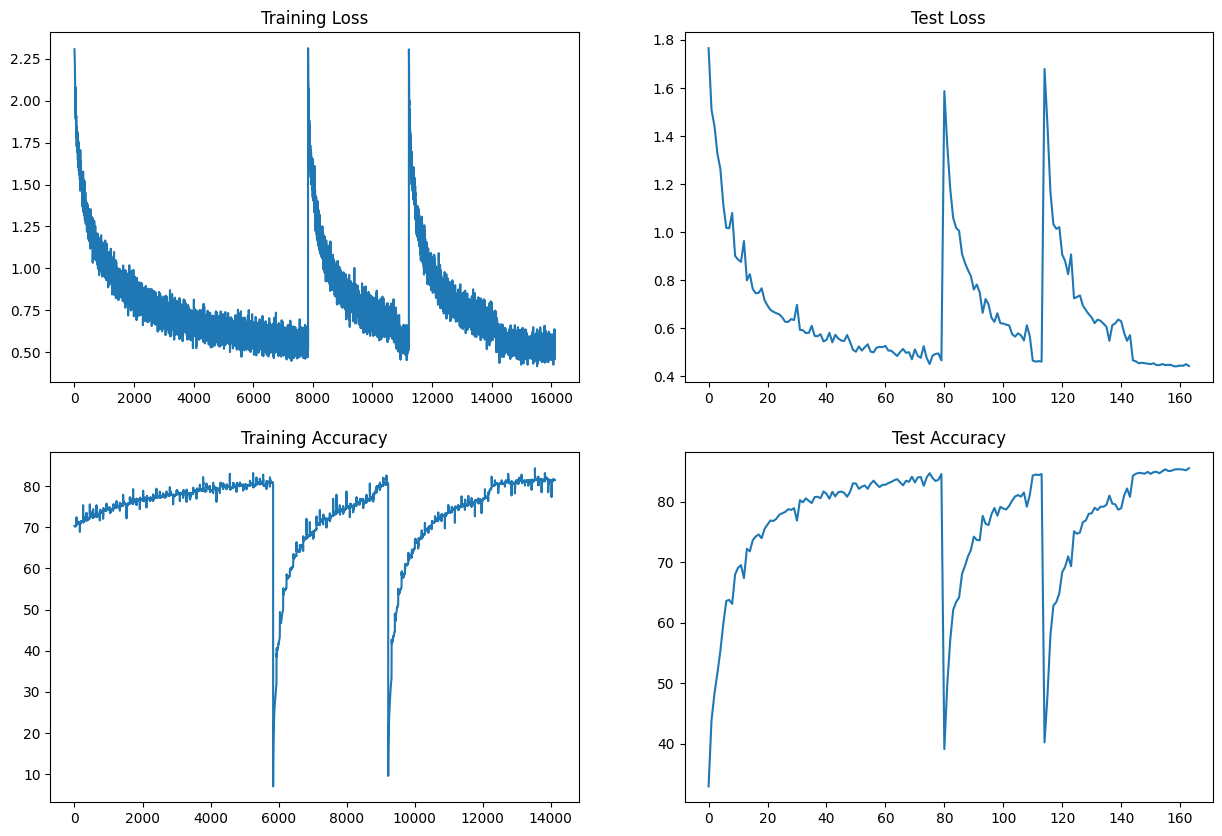

In [120]:
train_losses = [t_items.item() for t_items in train_losses]
plot_performance(train_losses, train_acc, test_losses, test_acc)

In [124]:
model.eval()
test_loss = 0
correct = 0
i =0
misclassified_dict = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        t = pred.eq(target.view_as(pred)).view(-1, target.size(0))
        t = t.cpu().numpy().reshape(-1)
        for ind,val in enumerate(t):
          if not val :
            temp_dict = {}
            temp_dict['data'] = data[ind].cpu().numpy()
            temp_dict['target'] = target[ind]
            temp_dict['pred'] = pred[ind]
            misclassified_dict.append(temp_dict)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


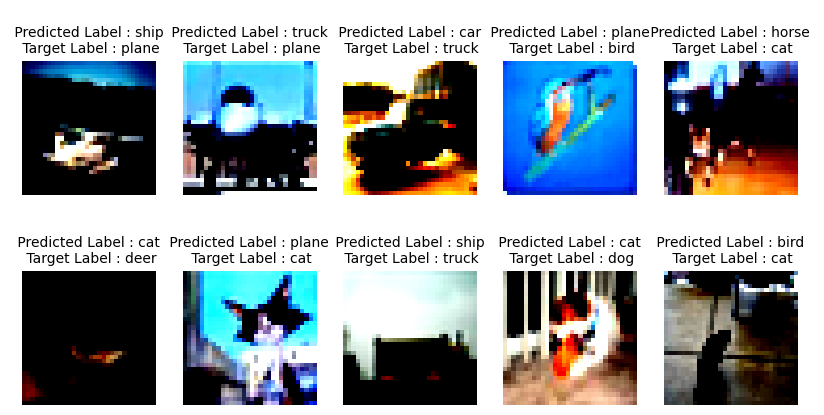

In [132]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
display_images = misclassified_dict[:10]
index = 0
fig = plt.figure(figsize=(10,5))
for img in display_images:
    image = img['data']
    pred = classes[img['pred']]
    actual = classes[img['target']]
    ax = fig.add_subplot(2, 5, index+1)
    ax.axis('off')
    ax.set_title(f'\n Predicted Label : {pred} \n Target Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(image, (1, 2, 0)))
    index = index + 1
plt.show()